In [1]:
!pip install -U tensorflow-addons

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [4]:
import tensorflow_addons as tfa

In [5]:
print(tf.__version__)

2.7.0


In [6]:
ls -al /content/drive/MyDrive/dataset

total 8
drwx------ 4 root root 4096 Mar 16  2021 test/
drwx------ 4 root root 4096 Mar 16  2021 train/


In [7]:
imagePaths = "/content/drive/MyDrive/dataset/train"

In [8]:
test_path="/content/drive/MyDrive/dataset/test"

In [9]:
batch_size=8
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1971 files belonging to 2 classes.
Using 1577 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1971 files belonging to 2 classes.
Using 394 files for validation.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 510 files belonging to 2 classes.


In [12]:
x_train= tf.concat([x for x, y in train_ds], axis=0)

In [13]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [14]:
x_test= tf.concat([x for x, y in test_ds], axis=0)
y_test= tf.concat([y for x, y in test_ds], axis=0)

In [15]:
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 5
image_size = 180  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 180
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(8, 180, 180, 3)
(8,)


In [17]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [18]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 180 X 180
Patch size: 6 X 6
Patches per image: 900
Elements per patch: 108


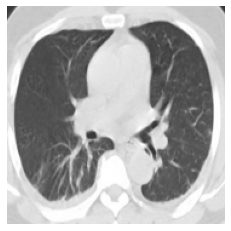

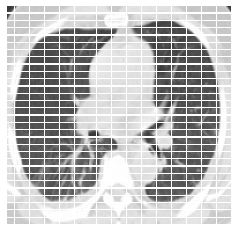

In [19]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

In [20]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [21]:
input_shape=(180, 180, 3)

In [22]:
num_classes = 2

In [23]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    #augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [24]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/5
178/178 [==============================] - 170s 901ms/step - loss: 67.8107 - accuracy: 0.4975 - top-5-accuracy: 1.0000 - val_loss: 3.8084 - val_accuracy: 0.4620 - val_top-5-accuracy: 1.0000
Epoch 2/5
178/178 [==============================] - 90s 504ms/step - loss: 3.2630 - accuracy: 0.5046 - top-5-accuracy: 1.0000 - val_loss: 0.6957 - val_accuracy: 0.4620 - val_top-5-accuracy: 1.0000
Epoch 3/5
178/178 [==============================] - 156s 879ms/step - loss: 0.6930 - accuracy: 0.5102 - top-5-accuracy: 1.0000 - val_loss: 0.6925 - val_accuracy: 0.5380 - val_top-5-accuracy: 1.0000
Epoch 4/5
178/178 [==============================] - 88s 494ms/step - loss: 0.6928 - accuracy: 0.4933 - top-5-accuracy: 1.0000 - val_loss: 0.6962 - val_accuracy: 0.4620 - val_top-5-accuracy: 1.0000
Epoch 5/5
16/16 [==============================] - 8s 495ms/step - loss: 0.6932 - accuracy: 0.5000 - top-5-accuracy: 1.0000
Test accuracy: 50.0%
Test top 5 accuracy: 100.0%


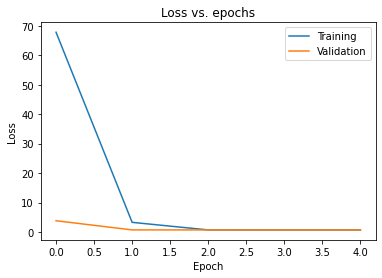

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

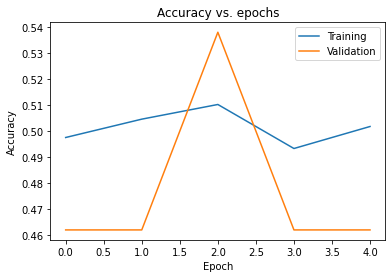

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [27]:
results = vit_classifier.evaluate(test_ds, verbose=2)

64/64 - 9s - loss: 0.6932 - accuracy: 0.5000 - top-5-accuracy: 1.0000 - 9s/epoch - 137ms/step


In [28]:
results

[0.6931843757629395, 0.5, 1.0]

In [29]:
y_pred=vit_classifier.predict(test_ds)

In [30]:
predicted_categories = tf.argmax(y_pred, axis=1)

In [31]:
true_categories = tf.concat([y for x, y in test_ds], axis=0)

In [32]:
y_pred_keras = vit_classifier.predict(x_test)

In [33]:
y_pred=np.array([])
for i in y_pred_keras:
  if i[0] > i[1]:
    y_pred=np.append(y_pred, i[0])
  else:
    y_pred=np.append(y_pred, i[1])

In [34]:
from sklearn.metrics import roc_curve

In [35]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)

In [36]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [37]:
auc_keras

0.5

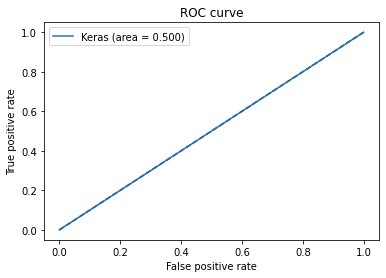

In [38]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [39]:
confusion_matrix= tf.math.confusion_matrix(predicted_categories, true_categories)

In [40]:
confusion_matrix=confusion_matrix.numpy()

In [41]:
confusion_matrix

array([[  0,   0],
       [255, 255]], dtype=int32)

In [42]:
true_positive=confusion_matrix[0][0]
false_positive=confusion_matrix[0][1]
false_negative=confusion_matrix[1][0]
true_negative=confusion_matrix[1][1]

In [43]:
accuracy=(true_positive+ true_negative)/(true_positive+false_positive+false_negative+true_negative)

In [44]:
accuracy

0.5

In [45]:
precision=true_positive/(true_positive+false_positive)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in int_scalars
  """Entry point for launching an IPython kernel.


In [46]:
precision

nan

In [47]:
recall=true_positive/(true_positive+false_negative)

In [48]:
recall

0.0

In [49]:
f1=2*((precision*recall)/(precision+recall))

In [50]:
f1

nan